In [1]:
import ast
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import random
import re
import sys
import torch

from collections import deque
from graph_utils import plot_network
from python_tsp.exact import solve_tsp_dynamic_programming
from sklearn.model_selection import ParameterGrid
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
from pulp import *
from tensorboardX import SummaryWriter
from time import time
from torchsummary import summary

from agent import Agent
from env import MVCEnv, TSPEnv
from model import QNetwork
from solver import solve, solve2

%load_ext autoreload
%autoreload 2

In [2]:
def run_episode(agent, env, eps=0, train_mode=True, print_actions=False):
    state = env.reset()
    agent.reset_episode(env.G)
    score = 0
    while True:
        action = agent.act(state, eps=eps)
        if print_actions:
            print(action)
        next_state, reward, done = env.step(action)
        score += reward
        if train_mode:
            agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
    return score

In [3]:
def get_solver_solution(env):
    node_names = list(map(str, range(env.n)))
    node_vars = LpVariable.dicts("Node", node_names, 0, 1, LpInteger)

    prob = LpProblem("myProblem", LpMinimize)
    prob += lpSum(node_vars)

    for (u, v) in env.G.edges:
        prob += node_vars[str(u)] + node_vars[str(v)] >= 1

    prob.solve(PULP_CBC_CMD(msg=False))
    return value(prob.objective)

In [4]:
def get_solution(env, exact_solution_max_size=0, return_path=False):
    if env.G.number_of_nodes() <= exact_solution_max_size:
        raise NotImplemented("Exact solution not implemented yet")
    else:
        return get_solver_solution(env)

In [5]:
def run_validation(agent, env, n_episodes_validation, exact_solution_max_size=0, print_to_file=sys.stdout):
    agent.qnetwork_target.eval()
    agent.qnetwork_local.eval()
    val_scores = []
    isolated = []
    isolated_in_sol = []
    for i in range(1, n_episodes_validation+1):
        run_episode(agent, env, train_mode=False)
        score = env.get_solution_score()
        solution = get_solution(env, exact_solution_max_size)
        approximation_ratio = score/solution
        val_scores.append(approximation_ratio)
        cnt = 0
        cnt_in_sol = 0
        for v in env.G:
            if env.G.degree[v] == 0:
                cnt += 1
                if env.xv[v] == 1:
                    cnt_in_sol += 1
        isolated.append(cnt)
        isolated_in_sol.append(cnt_in_sol)
#         self.covered_edges += np.dot(self.graph_adj_matrix[action], 1 - self.xv)
    
    val_scores = np.array(val_scores)
    val_stats = pd.Series(val_scores).describe()
    print(
        f"[Validation] "
        f"Mean: {val_stats['mean']}, "
        f"Std dev: {val_stats['std']}, "
        f"Optimal: {100 * (abs(val_scores - 1.0) < 1e-6).sum() / n_episodes_validation :.2f}%",
        f"Isolated: {sum(isolated_in_sol)/len(isolated_in_sol)} / {sum(isolated)/len(isolated)}",
        file=print_to_file
    )
    
    agent.qnetwork_target.train()
    agent.qnetwork_local.train()

    return val_stats

In [6]:
# Function to log weights and gradients
def log_weights_and_gradients(model, writer, episode):
    for name, param in model.named_parameters():
#         print(f"{name=}, {param=}, {episode=}")
        writer.add_histogram(f"weights/{name}", param, episode)
        if param.grad is not None:
            writer.add_histogram(f"gradients/{name}", param.grad, episode)

In [7]:
def train(agent, env, eps_start, eps_decay, eps_end, scheduler=None, n_episodes=10000, start_episode=1,
          validate_each=25, n_episodes_validation=10, print_train_metrics_each=100, print_thetas=True,
          validate_at_start=True, print_to_file=sys.stdout, experiment_idx=None, run_idx=None):
    
    # Set up TensorBoard logging
    if experiment_idx is not None:
        log_file = "exp_{}{}".format(experiment_idx, f"_{run_idx}" if run_idx is not None else "")
    else:
        log_file = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join("logs-mvc", "fit", log_file)
    writer = SummaryWriter(log_dir)
    
    scores = []
    val_scores = []
    eps = eps_start
    start_time = time()
    if validate_at_start:
        val_score = run_validation(agent, env, n_episodes_validation, print_to_file=print_to_file)['mean']
        val_scores.append(val_score)
    for episode_idx in range(start_episode, n_episodes + 1):
        try:
            # run episode for given episode_idx
            episode_score = run_episode(agent, env, eps, train_mode=True)
            episode_loss = agent.losses[-1] if len(agent.losses) > 0 else None
            eps = max(eps * eps_decay if eps_decay >= 0 else eps + eps_decay, eps_end)
            scores.append(episode_score)

            # update the LR scheduler
            if isinstance(scheduler, LambdaLR):
                scheduler.step()

            if episode_idx % print_train_metrics_each == 0:
                print(
                    f"[{episode_idx}/{n_episodes}] "
                    f"loss: {agent.losses[-1]:.3e}, "
                    f"q_target: {agent.q_targets[-1]:.3e}, "
                    f"q_expected: {agent.q_expecteds[-1]:.3e}, "
                    f"eps: {eps:.4f}, "
                    f"time: {time() - start_time:.2f}s",
                    file=print_to_file,
                    flush=True
                )
                if print_thetas:
                    print(f"    θ1: {agent.theta1s[-1]:.3e}, "
                        f"θ2: {agent.theta2s[-1]:.3e}, "
                        f"θ3: {agent.theta3s[-1]:.3e}, "
                        # f"θ4: {agent.theta4s[-1]:.3e}, "
                        f"θ5: {agent.theta5s[-1]:.3e}, "
                        f"θ6: {agent.theta6s[-1]:.3e}, "
                        f"θ7: {agent.theta7s[-1]:.3e}",
                        file=print_to_file
                    )

            # check if we should run validation
            if episode_idx % validate_each == 0:
                val_score = run_validation(agent, env, n_episodes_validation, print_to_file=print_to_file)['mean']
                if isinstance(scheduler, ReduceLROnPlateau):
                    scheduler.step(val_score)
                val_scores.append(val_score)

            # Log weights and gradients
            log_weights_and_gradients(agent.qnetwork_local, writer, episode_idx)

            # Log the episode reward
            writer.add_scalar('Episode Reward', episode_score, episode_idx)
            # Optionally log the loss
            if episode_loss is not None:
                writer.add_scalar('Loss', episode_loss, episode_idx)

        except KeyboardInterrupt:
            print(f"Training interrupted in episode #{episode_idx}")
            break
    print(f"Total time: {time() - start_time:.2f}s", file=print_to_file)

    # Close Tensorboard writer
    writer.close()

    return scores, val_scores

In [8]:
def eps_analysis(eps_start, eps_decay, eps_end, n, decay, check_episodes=35000):
    if decay == 'exponential':
        return np.argmin([eps_start * (eps_decay ** (n*i)) > eps_end for i in range(check_episodes)])
    elif decay == 'linear':
        return 0
    raise ValueError('decay should be either "exponential" or "linear"')

In [9]:
def lr_lambda(lr_config):
    '''
    lr_config: list of tuples (start_episode, lr_value)
    '''
    def f(episode):
        for i in range(len(lr_config) - 1, -1, -1):
            start_episode, lr_value = lr_config[i]
            if episode >= start_episode:
                return lr_value
        raise ValueError("lr_config should have its first element starting at episode 0")
    return f

In [23]:
def plot_graphs(agent_losses, val_scores, max_loss=1.0, filename=None, **kwargs):
    agent_losses = np.atleast_2d(agent_losses)
    val_scores = np.atleast_2d(val_scores)    

    title_keys = ['n', 'lr_config', 'batch_size']
    title_config = ', '.join([f'{k} = {kwargs[k]}' for k in title_keys])
    # title_config = f'n = {n}, lr = {lr_config}'
    fig, ax = plt.subplots(2, 1, figsize=(10,8))

    losses_df = pd.DataFrame(agent_losses).T
    losses_df.plot(color='b', alpha=0.05, legend=False, xlabel='Minibatch', ylabel='Loss Value', ax=ax[0]);
    losses_df.mean(axis=1).plot(color='r', title=f'Loss Function\n{title_config}', ax=ax[0]);

    ax[0].set_title(f'Loss function\n{title_config}')
    ax[0].set_ylim((0, max_loss))

    val_df = pd.DataFrame(val_scores).T
    val_x_start = 0 if kwargs.get('validate_at_start', False) else 1
    val_x = pd.DataFrame({'x': np.arange(val_x_start, len(val_scores[0]) + 1) * kwargs.get('validate_each', 1)})

    pd.concat([val_df, val_x], axis=1).plot(x='x', color='b', alpha=0.05, legend=False, xlabel='Validation Episode', ylabel='Approximation Ratio', ax=ax[1]);
    val_df_mean = val_df.mean(axis=1)
    print(f'Min of avg validation score across episodes: {val_df_mean.min()}')
    pd.concat([val_df_mean, val_x], axis=1).plot(x='x', color='r', legend=False, title=f'Validation scores\n{title_config}', ax=ax[1]);
    ax[1].set_title('Validation scores')

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

In [24]:
def replay_graphs(outputs_prefix, max_loss=1.0, filename=None):
    with open(f'{outputs_prefix}_loss.log') as f:
        agent_losses_str = f.read()
    agent_losses = ast.literal_eval(agent_losses_str)
    with open(f'{outputs_prefix}_val.log') as f:
        val_scores_str = f.read()
    with open(f'{outputs_prefix}.log') as f:
        config_str = f.readlines()[0].strip()
    config = ast.literal_eval(config_str)
    val_scores = ast.literal_eval(val_scores_str)
    plot_graphs(
        agent_losses,
        val_scores,
        max_loss=max_loss,
        filename=filename,
        n=config['n'],
        lr_config=config['lr_config'],
        batch_size=config['batch_size'],
        validate_each=config.get('validate_each', 1),
        validate_at_start=config.get('validate_at_start', False)
    )

In [12]:
def run_train(n_runs, params, experiment_idx=None, filename='outputs-mvc/run_{}.{}'):
    if experiment_idx is None:
        folder = x[0] if len(x := 'outputs-mvc/run_{}.{}'.rsplit('/', 1)) > 1 else './'
        idxs = set(int(match[0]) for file in os.listdir(folder) if (match := re.findall('run_(\d+)\.log', file)) != [])
        experiment_idx = min(i for i in range(len(idxs) + 1) if i not in idxs)
        print('Experiment idx:', experiment_idx)

    all_agent_losses = []
    all_val_scores = []

    n = params['n']
    n_episodes = params['n_episodes']
    eps_start = params['eps_start']
    eps_end = params['eps_end']
    eps_end_at_episode = params['eps_end_at_episode']
    decay_type = params.get('decay_type', 'linear')
    batch_size = params['batch_size']
    validate_at_start = params.get('validate_at_start', False)

    # transform relative to absolute episode number
    lr_config = params['lr_config']
    lr_config = [(int(ep * n_episodes), lr) if 0 < ep <= 1 else (ep, lr) for (ep, lr) in lr_config]

    f_log = open(filename.format(experiment_idx, 'log'), 'w')
    f_loss = open(filename.format(f'{experiment_idx}_loss', 'log'), 'w')
    f_val = open(filename.format(f'{experiment_idx}_val', 'log'), 'w')
    filename_plot = filename.format(experiment_idx, 'png')

    env_kwargs = {}
    if (graph_param := params.get('graph_param')):
        env_kwargs['graph_param'] = graph_param

    print(params)
    print(params, file=f_log)

    agents = []
    for run_idx in range(n_runs):
        agent = Agent(
            nstep=params.get('nstep', 1),
            normalize=params.get('normalize', True),
            batch_size=batch_size,
            lr=1, # LR is set via LR scheduler  
            n_node_features=1,
            n_edge_features=0,
            T=5
        )

        env = MVCEnv(n_min=n, n_max=n, graph_type=params['graph_type'], **env_kwargs)

        scheduler = LambdaLR(agent.optimizer, lr_lambda=lr_lambda(lr_config), verbose=False)

        if 0 < eps_end_at_episode <= 1:
            eps_end_at_episode = round(eps_end_at_episode * n_episodes)

        if decay_type == 'exponential':
            # exponential decay derived from formula eps_end = eps_start * (eps_decay ** episode)
            eps_decay = (eps_end / eps_start) ** (1 / eps_end_at_episode)
        elif decay_type == 'linear':
            # linear decay derived from formula eps_end = eps_start + (eps_decay * episode)
            eps_decay = (eps_end - eps_start) / eps_end_at_episode

        print(f'Starting run #{run_idx+1}/{n_runs}...')
        print(f'Starting run #{run_idx+1}/{n_runs}...', file=f_log)
        scores, val_scores = train(
            agent,
            env,
            eps_start,
            eps_decay,
            eps_end,
            scheduler=scheduler,
            n_episodes=n_episodes,
            validate_each=params['validate_each'],
            print_train_metrics_each=params['print_train_metrics_each'],
            print_thetas=False,
            print_to_file=f_log,
            validate_at_start=validate_at_start,
            experiment_idx=experiment_idx,
            run_idx=run_idx,
        )

        agents.append(agent)
        print(type(agent.losses), len(agent.losses))
        print(type(val_scores), len(val_scores))
        all_agent_losses.append(agent.losses)
        all_val_scores.append(val_scores)

    # print(f"{filename.format(experiment_idx, 'log')=}")
    # print(f"{filename.format(f'{experiment_idx}_loss', 'log')=}")
    # print(f"{filename.format(f'{experiment_idx}_val', 'log')=}")
    # print(f"{all_agent_losses=}")
    # print(f"{all_val_scores=}")

    # TODO: remove [0]
    print(all_agent_losses[0], file=f_loss)
    print(all_val_scores, file=f_val)

    f_log.close()
    f_loss.close()
    f_val.close()
#     with open(filename.format(f'{experiment_idx}_loss', 'log'), 'w') as f:
#         f.write(str(all_agent_losses))

#     with open(filename.format(f'{experiment_idx}_val', 'log'), 'w') as f:
#         f.write(str(all_val_scores))

    # print(filename.format(experiment_idx, 'png'))
    # TODO: remove [0] from all_agent_losses[0]
    plot_graphs(
        all_agent_losses[0],
        all_val_scores,
        max_loss=1,
        filename=filename_plot,
        n=n,
        lr_config=lr_config,
        batch_size=batch_size,
        validate_each=params['validate_each'],
        validate_at_start=validate_at_start
    )

    return agents

## Barabasi-Albert

Experiment idx: 29
{'n': 20, 'nstep': 2, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'graph_param': 4, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.05, 'eps_end_at_episode': 1.0, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/10...


/home/tiago/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


<class 'list'> 28737
<class 'list'> 20
Starting run #2/10...
<class 'list'> 29290
<class 'list'> 20
Starting run #3/10...
<class 'list'> 29325
<class 'list'> 20
Starting run #4/10...
<class 'list'> 28929
<class 'list'> 20
Starting run #5/10...
<class 'list'> 28588
<class 'list'> 20
Starting run #6/10...
<class 'list'> 28735
<class 'list'> 20
Starting run #7/10...
<class 'list'> 28571
<class 'list'> 20
Starting run #8/10...
<class 'list'> 28392
<class 'list'> 20
Starting run #9/10...
<class 'list'> 28712
<class 'list'> 20
Starting run #10/10...
<class 'list'> 28821
<class 'list'> 20
CPU times: user 4h 19min 46s, sys: 1min 37s, total: 4h 21min 24s
Wall time: 45min 6s


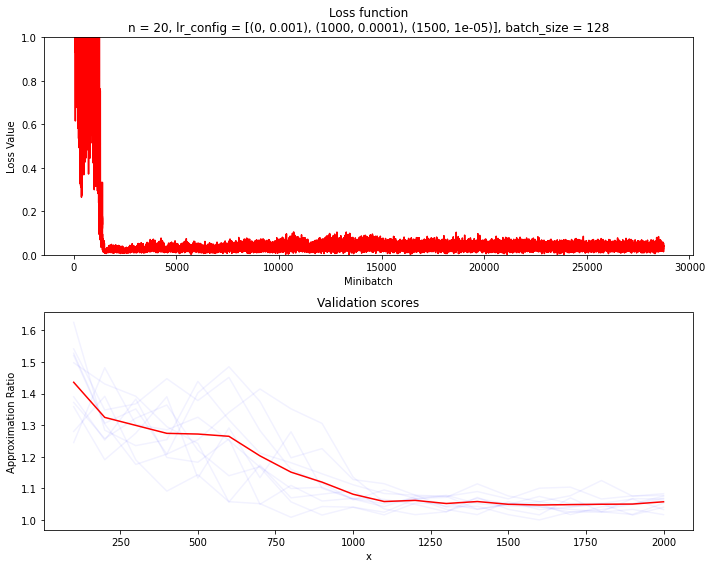

In [13]:
%%time
params = {
    'n': 20,
    'nstep': 2,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    'graph_param': 4,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.05,
    'eps_end_at_episode': 1.0,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(10, params)

Min of avg validation score across episodes: 1.0472843822843823


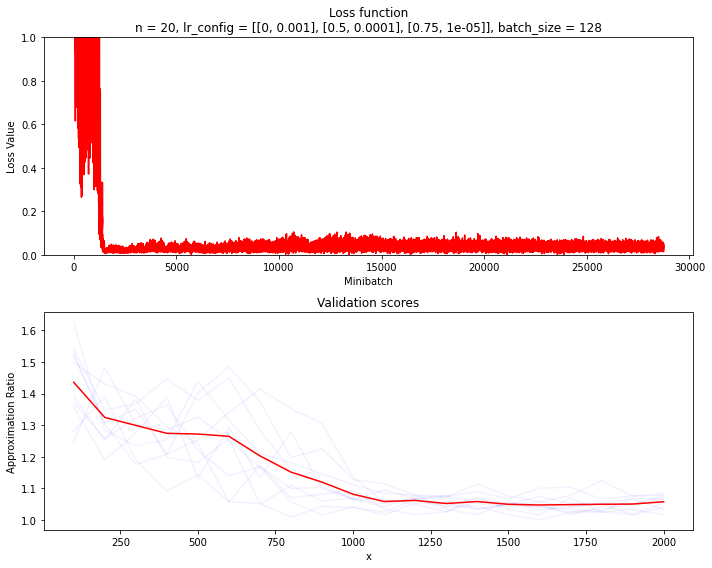

In [25]:
replay_graphs('outputs-mvc/run_29', max_loss=1e0, filename=None)

## Erdős–Rényi

Experiment idx: 31
{'n': 20, 'nstep': 2, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'graph_param': 0.4, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.05, 'eps_end_at_episode': 1.0, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/10...
<class 'list'> 31163
<class 'list'> 20
Starting run #2/10...
<class 'list'> 31184
<class 'list'> 20
Starting run #3/10...
<class 'list'> 31066
<class 'list'> 20
Starting run #4/10...
<class 'list'> 31166
<class 'list'> 20
Starting run #5/10...
<class 'list'> 31230
<class 'list'> 20
Starting run #6/10...
<class 'list'> 31727
<class 'list'> 20
Starting run #7/10...
<class 'list'> 31258
<class 'list'> 20
Starting run #8/10...
<class 'list'> 31227
<class 'list'> 20
Starting run #9/10...
<class 'list'> 31131
<class 'list'> 20
Starting run #10/10...
<class 'list'> 31208
<class 'list'> 20
CPU times: user 4h 46min 44s, sys: 2min 40s, total: 4h 49min 25s
Wall time: 51min 20s


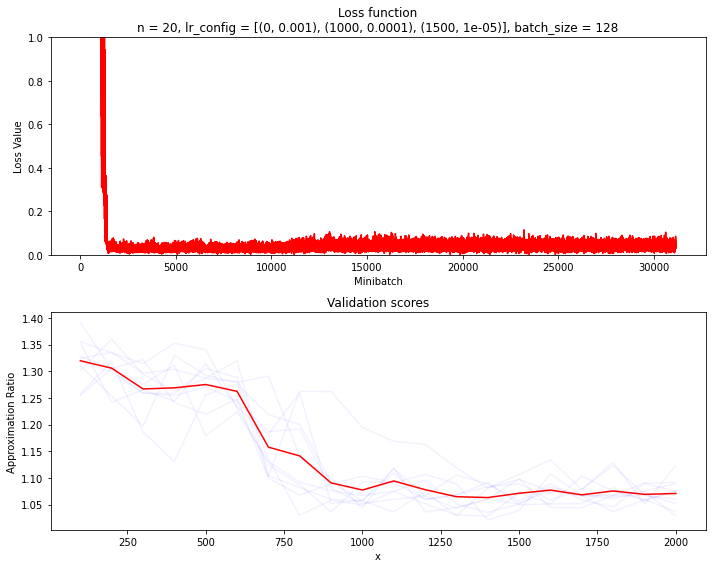

In [17]:
%%time
params = {
    'n': 20,
    'nstep': 2,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    'graph_param': 0.4,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.05,
    'eps_end_at_episode': 1.0,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(10, params)

Min of avg validation score across episodes: 1.06332967032967


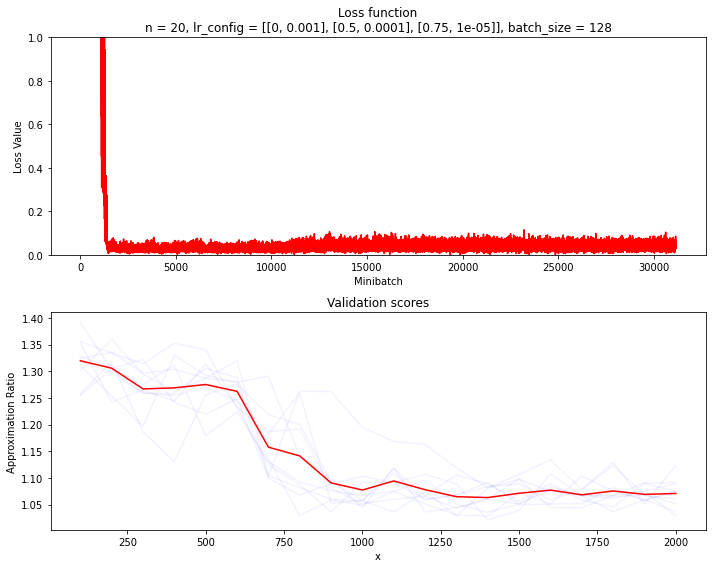

In [26]:
replay_graphs('outputs-mvc/run_31', max_loss=1e0, filename=None)

{'n': 20, 'nstep': -1, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'graph_param': 0.4, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.0, 'eps_end_at_episode': 0.8, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...


/home/tiago/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Starting run #2/2...
CPU times: user 56min 25s, sys: 14.2 s, total: 56min 39s
Wall time: 9min 16s


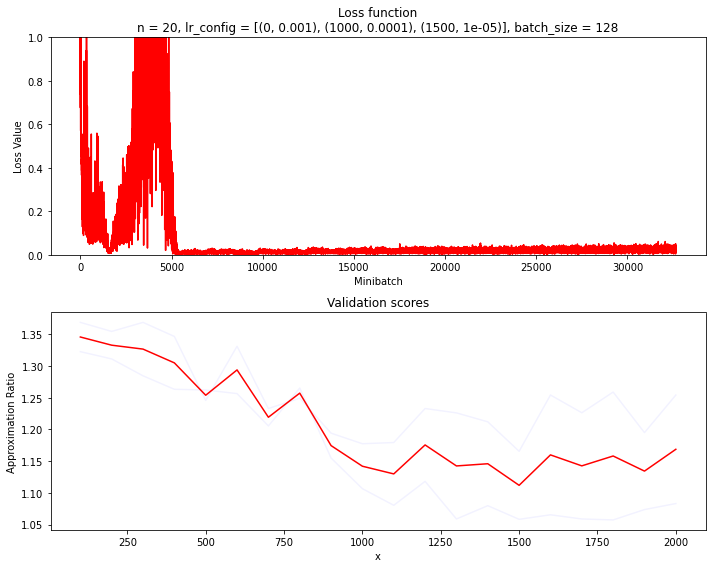

In [19]:
%%time
params = {
    'n': 20,
    'nstep': 1,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    'graph_param': 0.4,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.0,
    'eps_end_at_episode': 0.8,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(2, params, experiment_idx=23)

Experiment idx: 24
{'n': 20, 'nstep': 1, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'graph_param': 0.4, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.0, 'eps_end_at_episode': 0.8, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...
Starting run #2/2...
CPU times: user 56min 10s, sys: 16.3 s, total: 56min 26s
Wall time: 9min 6s


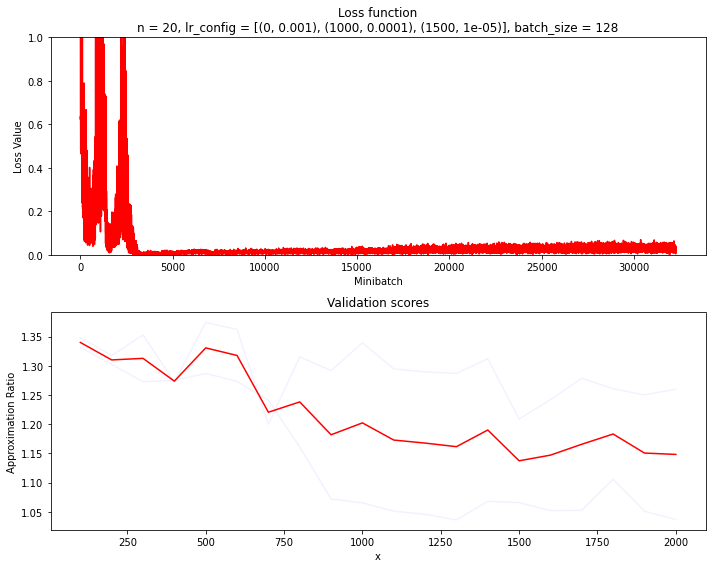

In [20]:
%%time
params = {
    'n': 20,
    'nstep': 1,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    'graph_param': 0.4,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.0,
    'eps_end_at_episode': 0.8,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(2, params)

Experiment idx: 25
{'n': 20, 'nstep': -1, 'lr_config': [[0, 0.1], [0.2, 0.01], [0.4, 0.001], [0.6, 0.0001], [0.8, 1e-05]], 'graph_type': 1, 'graph_param': 0.4, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.05, 'eps_end_at_episode': 1.0, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...
Starting run #2/2...
CPU times: user 1h 3min 11s, sys: 16.9 s, total: 1h 3min 27s
Wall time: 9min 53s


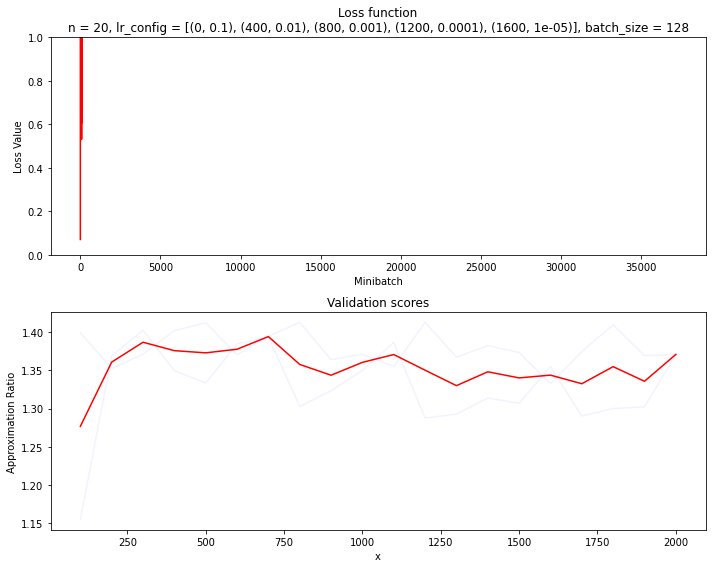

In [21]:
%%time
params = {
    'n': 20,
    'nstep': 1,
    'lr_config': [[0, 1e-1], [0.2, 1e-2], [0.4, 1e-3], [0.6, 1e-4], [0.8, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    'graph_param': 0.4,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.05,
    'eps_end_at_episode': 1.0,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(2, params)

{'n': 20, 'nstep': -1, 'lr_config': [[0, 0.01], [0.25, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'graph_param': 0.4, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.05, 'eps_end_at_episode': 1.0, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...
<class 'list'> 35165
<class 'list'> 20
Starting run #2/2...
<class 'list'> 35480
<class 'list'> 20
CPU times: user 56min 40s, sys: 14.5 s, total: 56min 55s
Wall time: 9min 12s


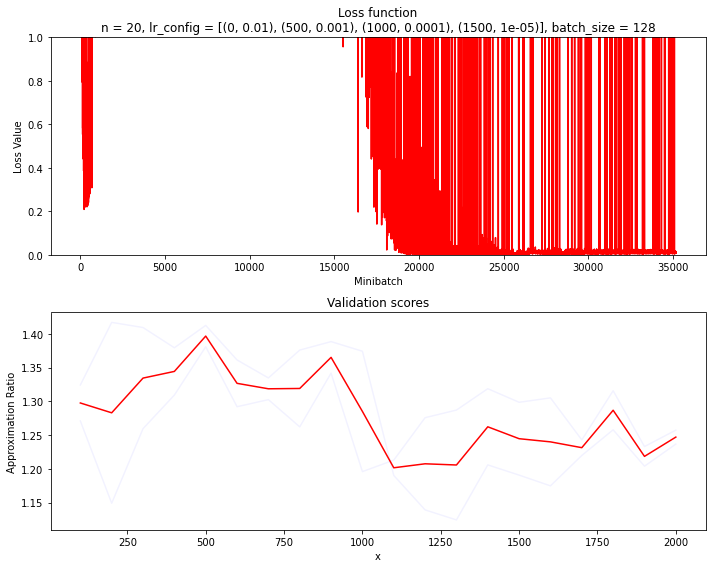

In [29]:
%%time
params = {
    'n': 20,
    'nstep': 1,
    'lr_config': [[0, 1e-2], [0.25, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    'graph_param': 0.4,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.05,
    'eps_end_at_episode': 1.0,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(2, params, experiment_idx=26)

Experiment idx: 27
{'n': 20, 'nstep': -1, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'graph_param': 4, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.05, 'eps_end_at_episode': 1.0, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...


/home/tiago/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


<class 'list'> 32584
<class 'list'> 20
Starting run #2/2...
<class 'list'> 34653
<class 'list'> 20
CPU times: user 59min 38s, sys: 19.1 s, total: 59min 57s
Wall time: 9min 56s


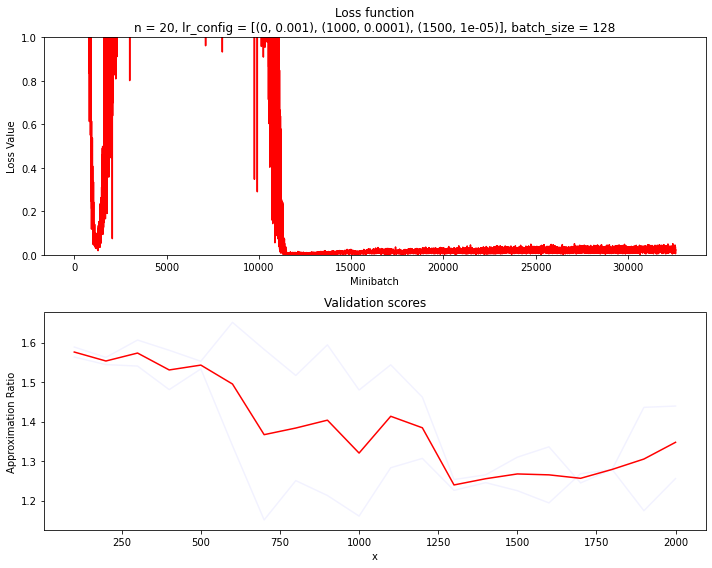

In [30]:
%%time
params = {
    'n': 20,
    'nstep': 1,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    'graph_param': 4,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.05,
    'eps_end_at_episode': 1.0,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(2, params)

Experiment idx: 28
{'n': 20, 'nstep': -1, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'graph_param': 4, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.05, 'eps_end_at_episode': 1.0, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...
<class 'list'> 33541
<class 'list'> 20
Starting run #2/2...
<class 'list'> 33680
<class 'list'> 20
CPU times: user 1h 6min 46s, sys: 24.8 s, total: 1h 7min 11s
Wall time: 11min 11s


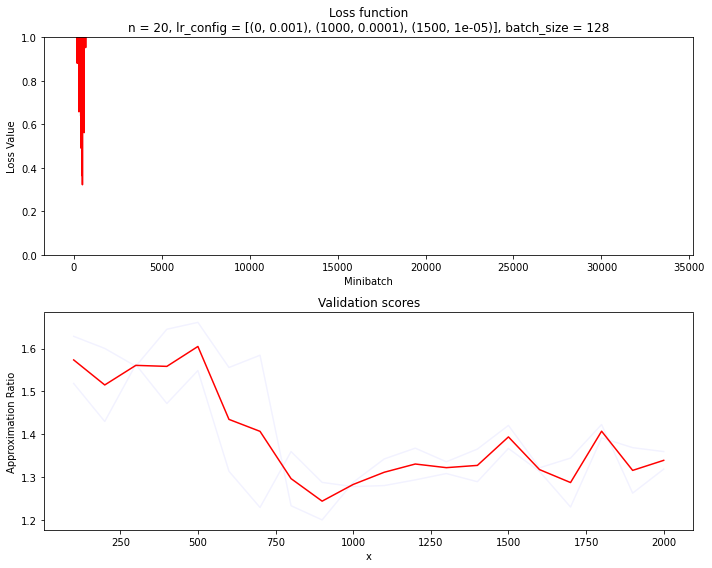

In [31]:
%%time
params = {
    'n': 20,
    'nstep': -1,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    'graph_param': 4,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.05,
    'eps_end_at_episode': 1.0,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(2, params)

Experiment idx: 20
{'n': 20, 'nstep': 5, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'graph_param': 0.3, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.0, 'eps_end_at_episode': 0.8, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/3...
Starting run #2/3...
Starting run #3/3...
CPU times: user 58min 25s, sys: 19 s, total: 58min 44s
Wall time: 10min 31s


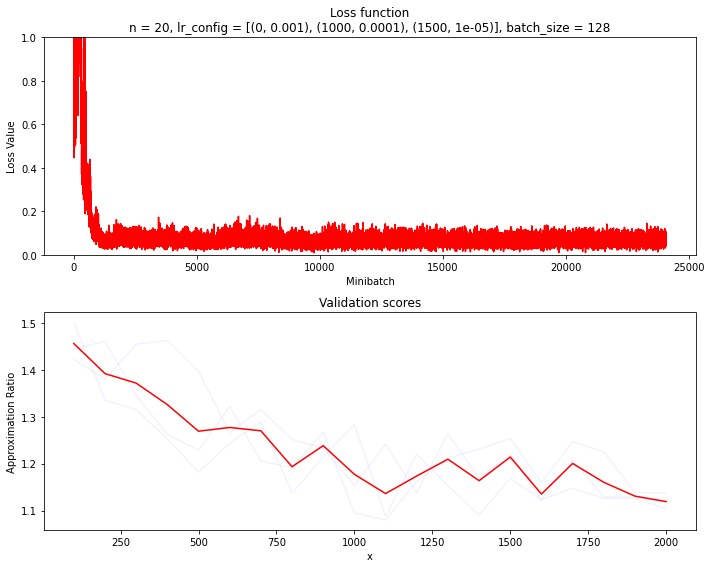

In [16]:
%%time
params = {
    'n': 20,
    'nstep': 5,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    'graph_param': 0.3,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.0,
    'eps_end_at_episode': 0.8,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(3, params)

Experiment idx: 19
{'n': 15, 'nstep': 5, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'graph_param': 4, 'n_episodes': 5000, 'eps_start': 1.0, 'eps_end': 0.0, 'eps_end_at_episode': 0.8, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...
Starting run #2/2...
CPU times: user 1h 1min 57s, sys: 32.4 s, total: 1h 2min 29s
Wall time: 13min 14s


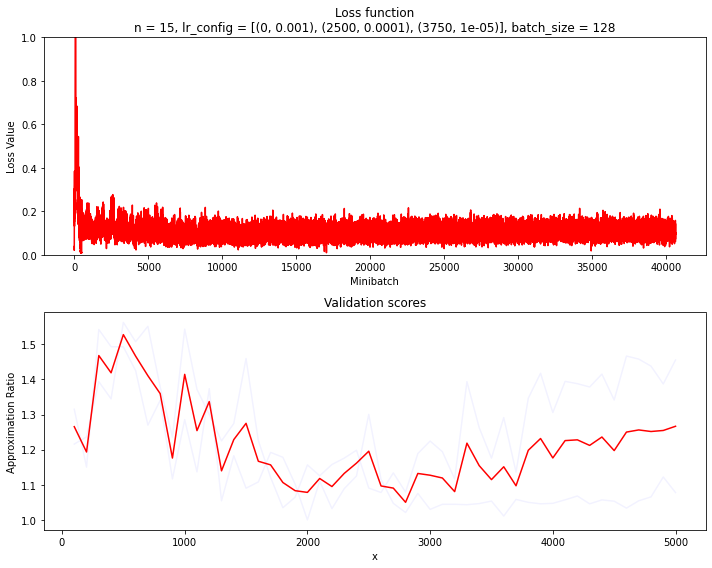

In [22]:
%%time
params = {
    'n': 15,
    'nstep': 5,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    'graph_param': 4,
    # 'n': [3, 4, 5],
    'n_episodes': 5000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.0,
    'eps_end_at_episode': 0.8,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(2, params)

Experiment idx: 21
{'n': 20, 'nstep': 2, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'graph_param': 0.3, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.05, 'eps_end_at_episode': 1.0, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...
Starting run #2/2...
CPU times: user 52min 49s, sys: 17.8 s, total: 53min 7s
Wall time: 9min


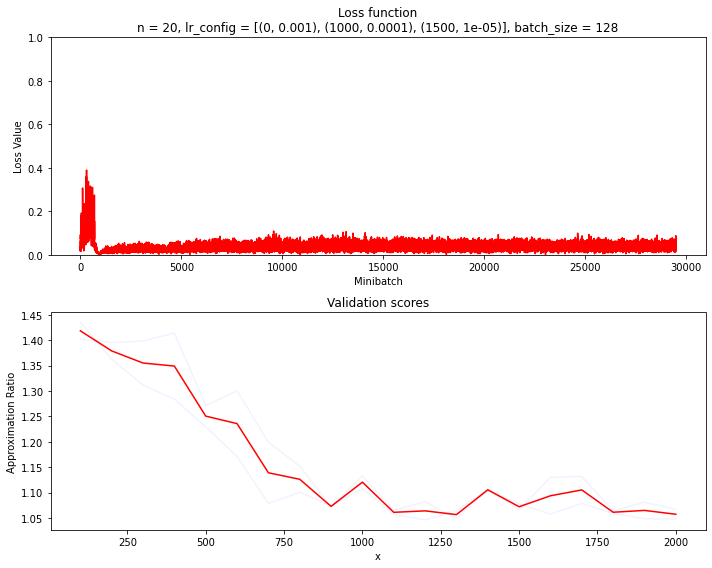

In [17]:
%%time
params = {
    'n': 20,
    'nstep': 2,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    'graph_param': 0.3,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.05,
    'eps_end_at_episode': 1.0,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(2, params)

{'n': 15, 'nstep': 5, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.0, 'eps_end_at_episode': 0.8, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...
Starting run #2/2...
CPU times: user 28min 27s, sys: 13 s, total: 28min 40s
Wall time: 4min 36s


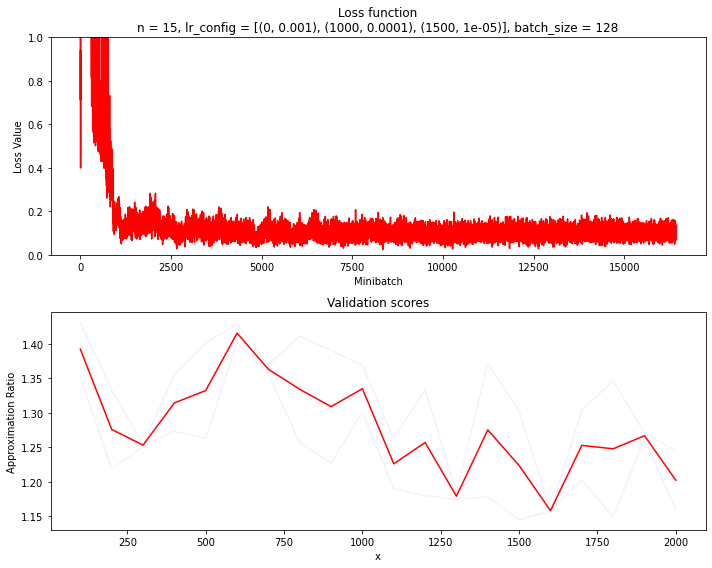

In [17]:
%%time
params = {
    'n': 15,
    'nstep': 5,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.0,
    'eps_end_at_episode': 0.8,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(4, 2, params)

{'n': 15, 'nstep': 5, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'n_episodes': 3000, 'eps_start': 1.0, 'eps_end': 0.0, 'eps_end_at_episode': 0.8, 'validate_each': 50, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...
Starting run #2/2...
CPU times: user 38min 41s, sys: 30.7 s, total: 39min 12s
Wall time: 6min 53s


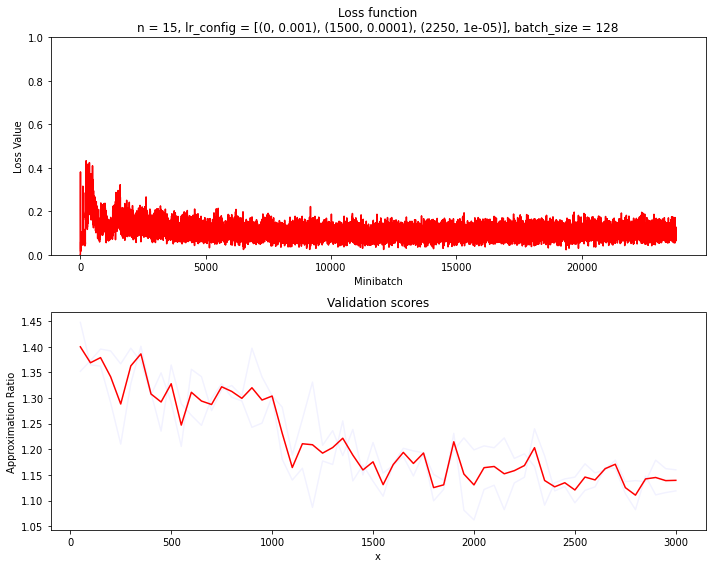

In [30]:
%%time
params = {
    'n': 15,
    'nstep': 5,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    # 'n': [3, 4, 5],
    'n_episodes': 3000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.0,
    'eps_end_at_episode': 0.8,
    'validate_each': 50,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(7, 2, params)

{'n': 20, 'nstep': 5, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'n_episodes': 10000, 'eps_start': 1.0, 'eps_end': 0.0, 'eps_end_at_episode': 0.8, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...
Starting run #2/2...
CPU times: user 2h 54min 45s, sys: 1min 36s, total: 2h 56min 22s
Wall time: 26min 27s


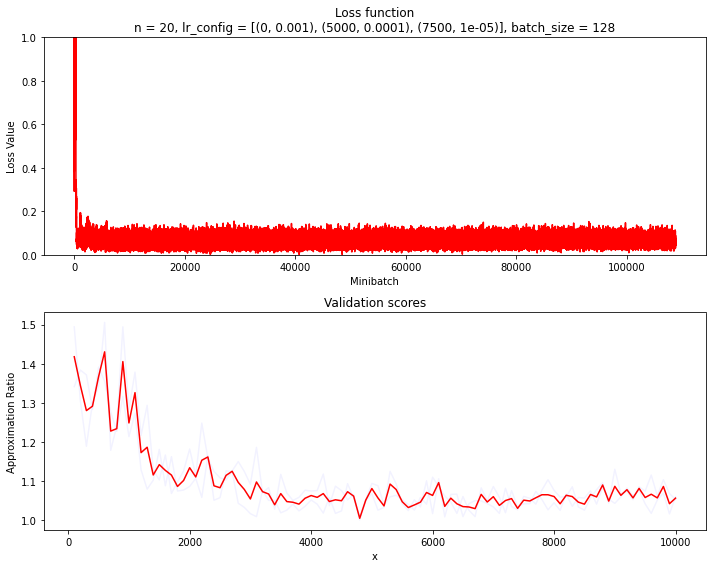

In [24]:
%%time
params = {
    'n': 20,
    'nstep': 5,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    # 'n': [3, 4, 5],
    'n_episodes': 10000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.0,
    'eps_end_at_episode': 0.8,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(2, 2, params)

In [17]:
mvc_env = MVCEnv(n_min=15, n_max=15, graph_type=MVCEnv.BARABASI_ALBERT)
state = mvc_env.reset()

In [18]:
summary(agents[0].qnetwork_local, state.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 15, 64]              64
            Linear-2               [-1, 15, 64]           4,096
    EmbeddingLayer-3               [-1, 15, 64]               0
            Linear-4               [-1, 15, 64]              64
            Linear-5               [-1, 15, 64]           4,096
    EmbeddingLayer-6               [-1, 15, 64]               0
            Linear-7               [-1, 15, 64]              64
            Linear-8               [-1, 15, 64]           4,096
    EmbeddingLayer-9               [-1, 15, 64]               0
           Linear-10               [-1, 15, 64]              64
           Linear-11               [-1, 15, 64]           4,096
   EmbeddingLayer-12               [-1, 15, 64]               0
           Linear-13               [-1, 15, 64]              64
           Linear-14               [-1,

In [18]:
agents[0].qnetwork_local

MPNN(
  (batch_norm_embedding): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding_layer): EmbeddingLayer(
    (theta1): Linear(in_features=1, out_features=64, bias=False)
    (theta2): Linear(in_features=64, out_features=64, bias=False)
    (theta3): Linear(in_features=64, out_features=64, bias=False)
    (theta4): Linear(in_features=0, out_features=64, bias=False)
  )
  (batch_norm_q): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (q_layer): QNetwork(
    (theta5): Linear(in_features=128, out_features=1, bias=False)
    (theta6): Linear(in_features=64, out_features=64, bias=False)
    (theta7): Linear(in_features=64, out_features=64, bias=False)
  )
)

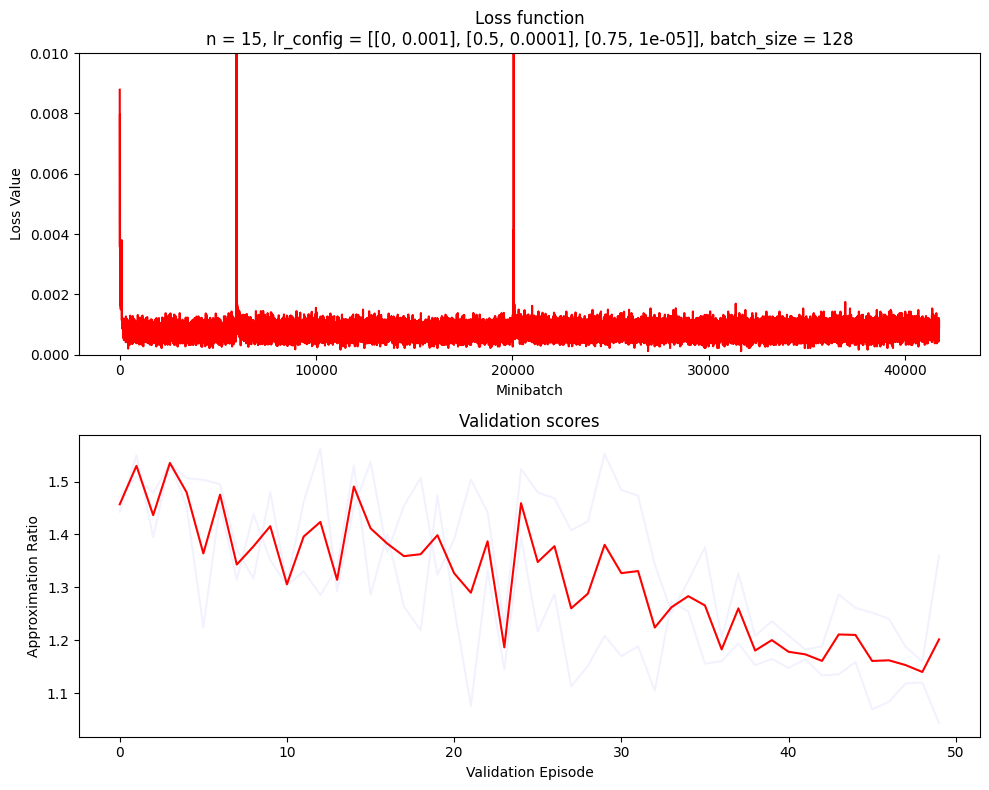

In [291]:
replay_graphs('outputs-mvc/run_3', max_loss=1e-2, filename=None)

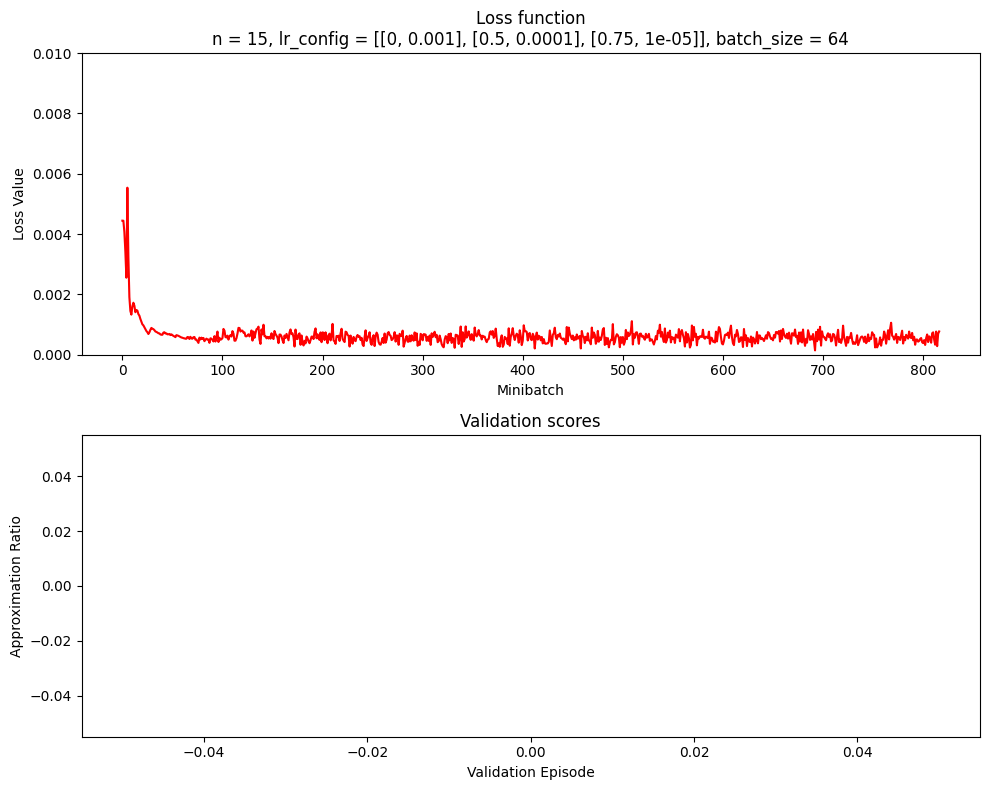

In [260]:
replay_graphs('outputs-mvc/run_0', max_loss=1e-2, filename=None)

{'n': 15, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.005, 'eps_end_at_episode': 0.8, 'validate_each': 1000000, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
Starting run #2/2...
CPU times: user 3min 37s, sys: 49.9 s, total: 4min 27s
Wall time: 4min 17s


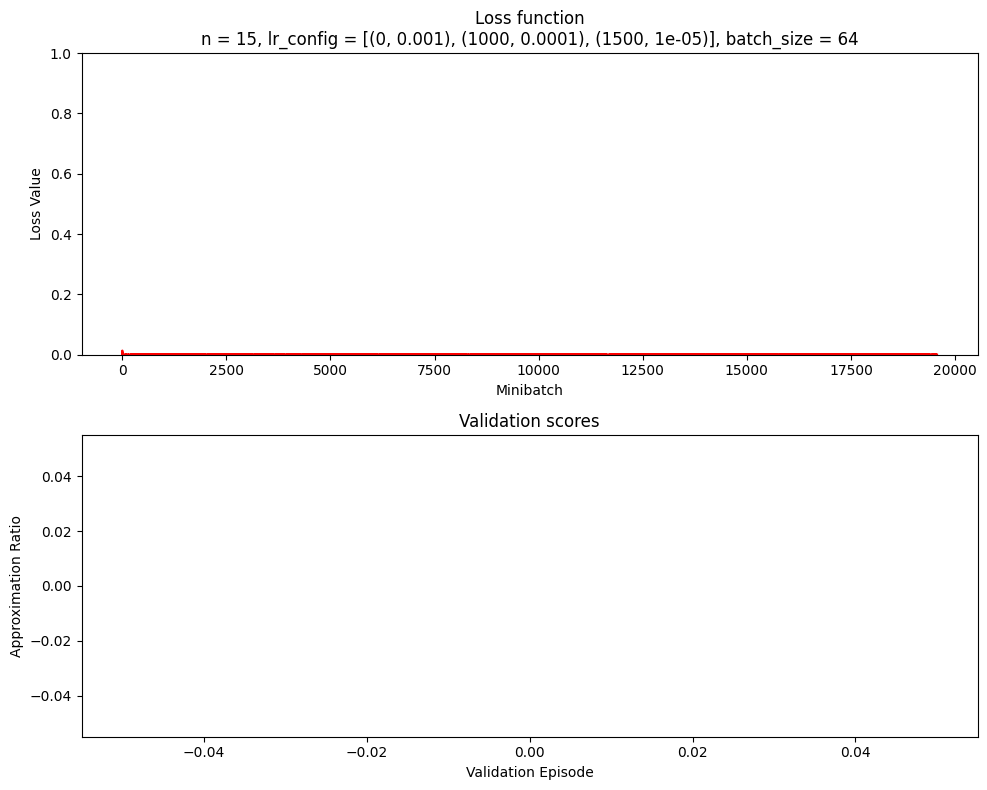

In [74]:
%%time
params = {
    'n': 15,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.005,
    'eps_end_at_episode': 0.8,
    'validate_each': 1000000,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
agents = run_train(1, 2, params)

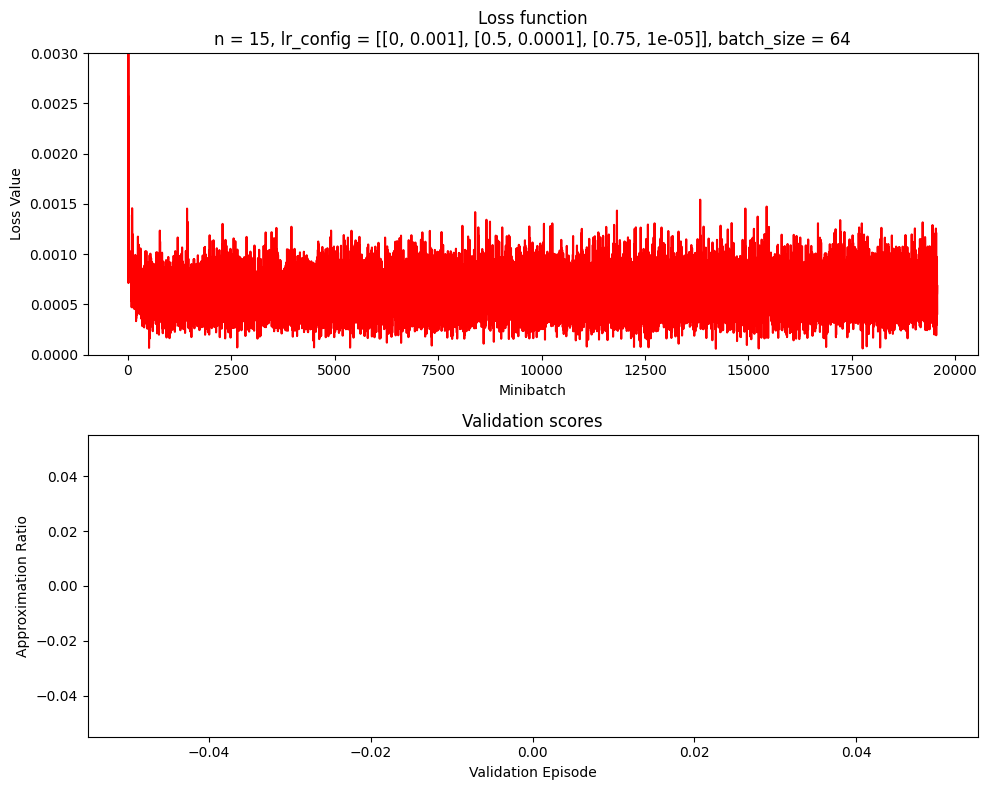

In [87]:
replay_graphs('outputs-mvc/run_1', max_loss=3e-3, filename=None)

## Linear epsilon decay

{'n': 15, 'nstep': 5, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'n_episodes': 5000, 'eps_start': 1.0, 'eps_end': 0.05, 'eps_end_at_episode': 1.0, 'decay_type': 'linear', 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #2/2...
CPU times: user 14min 36s, sys: 4min 33s, total: 19min 9s
Wall time: 1h 28min 27s


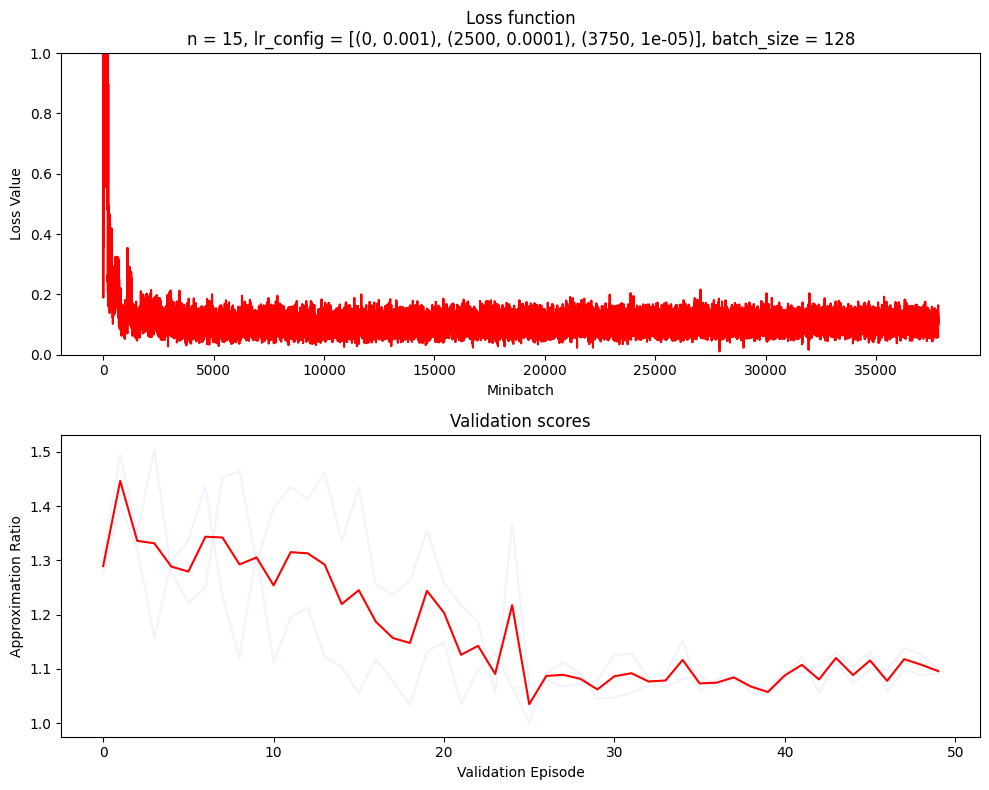

In [67]:
%%time

params = {
    'n': 15,
    'nstep': 5,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    # 'n': [3, 4, 5],
    'n_episodes': 5000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.05,
    'eps_end_at_episode': 1.0,
    'decay_type': 'linear',
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(4, 2, params)

{'n': 15, 'nstep': 5, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'n_episodes': 5000, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_end_at_episode': 1.0, 'decay_type': 'linear', 'validate_each': 250, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/3...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #2/3...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #3/3...
CPU times: user 20min 47s, sys: 4min 52s, total: 25min 39s
Wall time: 23min 23s


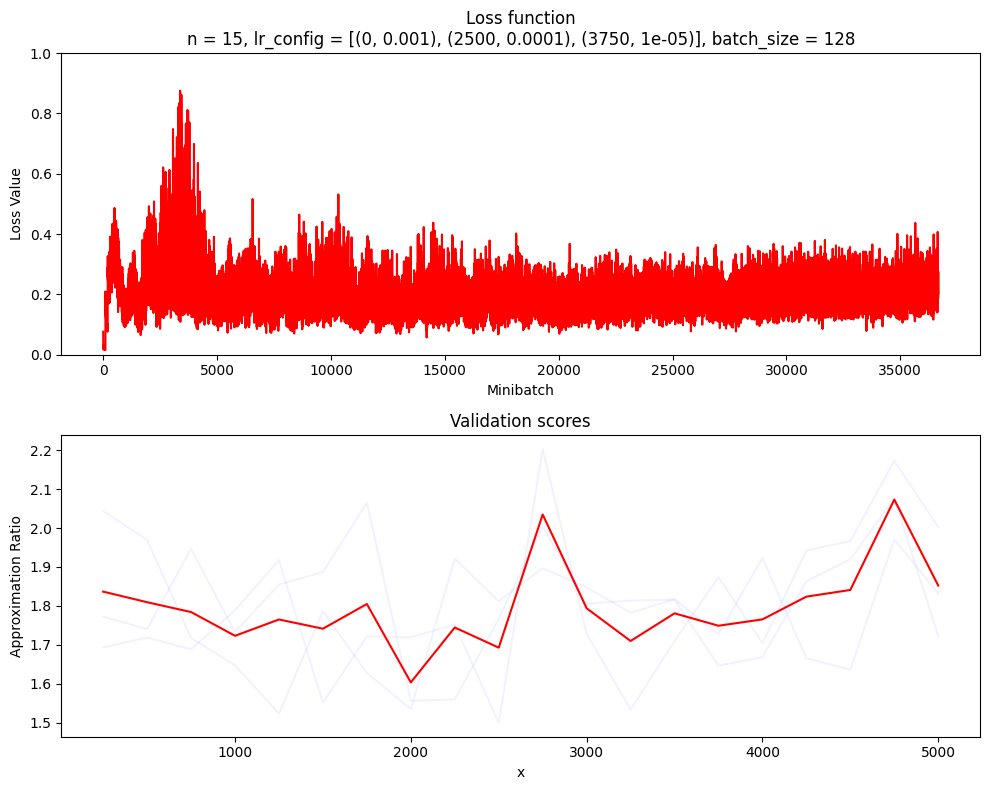

In [128]:
%%time

params = {
    'n': 15,
    'nstep': 5,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    # 'n': [3, 4, 5],
    'n_episodes': 5000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.01,
    'eps_end_at_episode': 1.0,
    'decay_type': 'linear',
    'validate_each': 250,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(6, 3, params)

{'n': 15, 'nstep': 1, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'n_episodes': 5000, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_end_at_episode': 1.0, 'decay_type': 'linear', 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/3...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #2/3...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #3/3...
CPU times: user 31min 31s, sys: 8min 44s, total: 40min 16s
Wall time: 36min 49s


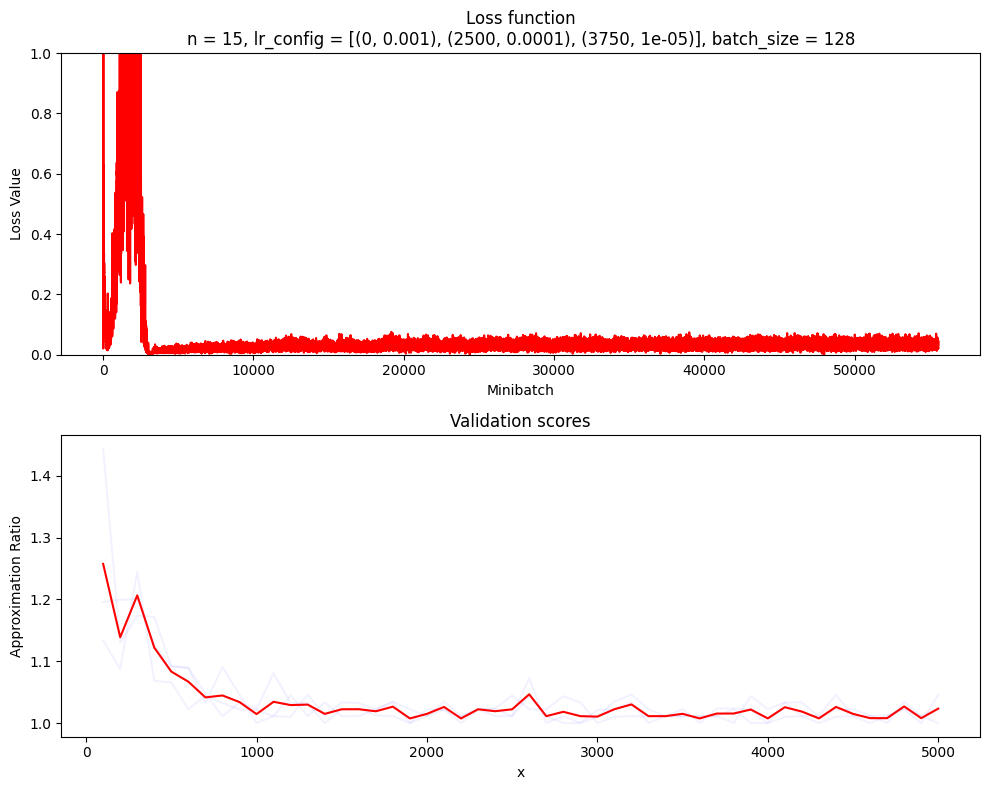

In [129]:
%%time

params = {
    'n': 15,
    'nstep': 1,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    # 'n': [3, 4, 5],
    'n_episodes': 5000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.01,
    'eps_end_at_episode': 1.0,
    'decay_type': 'linear',
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(6, 3, params)

{'n': 25, 'nstep': 5, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'n_episodes': 5000, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_end_at_episode': 1.0, 'decay_type': 'linear', 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/3...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #2/3...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #3/3...
CPU times: user 42min 55s, sys: 23min 16s, total: 1h 6min 12s
Wall time: 50min 35s


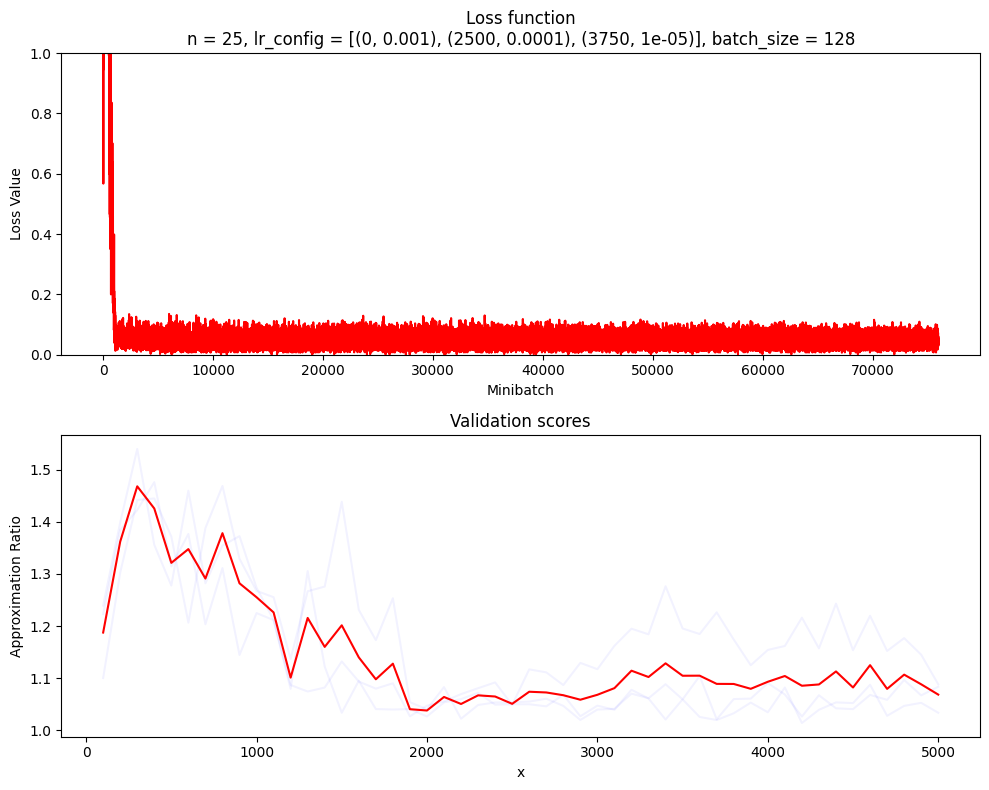

In [130]:
%%time

params = {
    'n': 25,
    'nstep': 5,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    # 'n': [3, 4, 5],
    'n_episodes': 5000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.01,
    'eps_end_at_episode': 1.0,
    'decay_type': 'linear',
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(7, 3, params)

In [26]:
n = 15
env = MVCEnv(n, n, graph_type=MVCEnv.BARABASI_ALBERT)
agent = Agent(
    nstep=1,
    normalize=True,
    batch_size=16,
    lr=1e-4, # LR is set via LR scheduler 
    n_node_features=1,
    n_edge_features=0,
    T=5
)

eps_start = 1.0
eps_end = 0.01
eps_end_at_episode = 0.9
eps_decay = (eps_end / eps_start) ** (1 / (n * eps_end_at_episode))
scores, val_scores = train(agent, env, eps_start, eps_decay,
                           eps_end, n_episodes=1000, validate_each=100000, validate_at_start=False)

[100/1000] loss: 1.209e-04, q_target: -7.548e-02, q_expected: -9.178e-02, eps: 0.0100, time: 3.33s
    θ1: -1.526e-01, θ2: -6.781e-02, θ3: 9.410e-03, θ5: 8.239e-02, θ6: 3.055e-02, θ7: -4.003e-02
[200/1000] loss: 3.744e-04, q_target: -7.401e-02, q_expected: -7.786e-02, eps: 0.0100, time: 6.48s
    θ1: -1.599e-01, θ2: -6.797e-02, θ3: 9.410e-03, θ5: 8.238e-02, θ6: 3.055e-02, θ7: -4.084e-02
[300/1000] loss: 1.068e-03, q_target: -7.455e-02, q_expected: -8.647e-02, eps: 0.0100, time: 9.93s
    θ1: -1.627e-01, θ2: -6.814e-02, θ3: 9.410e-03, θ5: 8.237e-02, θ6: 3.055e-02, θ7: -4.171e-02
[400/1000] loss: 3.568e-04, q_target: -7.481e-02, q_expected: -8.155e-02, eps: 0.0100, time: 13.19s
    θ1: -1.652e-01, θ2: -6.829e-02, θ3: 9.410e-03, θ5: 8.235e-02, θ6: 3.055e-02, θ7: -4.284e-02
[500/1000] loss: 2.072e-05, q_target: -7.501e-02, q_expected: -8.246e-02, eps: 0.0100, time: 16.56s
    θ1: -1.661e-01, θ2: -6.836e-02, θ3: 9.410e-03, θ5: 8.232e-02, θ6: 3.056e-02, θ7: -4.375e-02
[600/1000] loss: 3.639e

In [27]:
len(scores)

1000

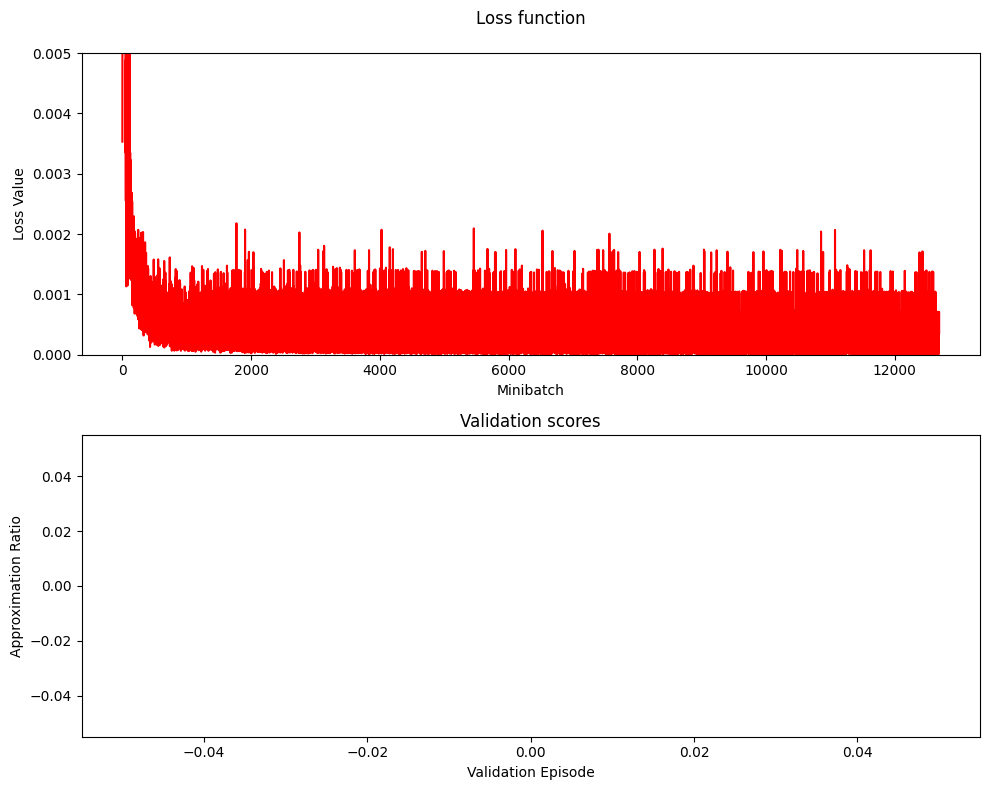

In [30]:
plot_graphs(agent.losses, [], max_loss=0.005)